# Seção 07.01 - Aprendizagem baseada em instâncias (KNN)
Para esta seção, usarei a base de dados "credit_data.csv" disponibilizada no curso do Professor Jones na UDEMY.

In [1]:
# Instruções basiconas de sempre.

# Lidar com dataframes.
import numpy as np
import pandas as pd

# Lidar com gráficos.
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
from plotting import (multiple_histograms_plot,
                      bar_plot_with_categorical,
                      plot_confusion_matrix,
                      plot_confusion_matrix_2,
                      plot_roc)

# Lidar com preparação de dados.
from data_prep import data_prep as dp # Eu que fiz esse modulinho ("uuuuuuuuuma bosts!").
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Lidar com validação de modelos.
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

In [2]:
nomeDaBase = "../bases/credit-data.csv"
df = pd.read_csv(nomeDaBase, sep=",", encoding="utf-8", index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1 to 2000
Data columns (total 4 columns):
income     2000 non-null float64
age        1997 non-null float64
loan       2000 non-null float64
default    2000 non-null int64
dtypes: float64(3), int64(1)
memory usage: 78.1 KB


In [4]:
df.describe()

,income,age,loan,default
count,2000.000000,1997.000000,2000.000000,2000.000000
mean,45331.600018,40.807559,4444.369695,0.141500
std,14326.327119,13.624469,3045.410024,0.348624
min,20014.489470,-52.423280,1.377630,0.000000
25%,32796.459717,28.990415,1939.708847,0.000000
50%,45789.117313,41.317159,3974.719419,0.000000
75%,57791.281668,52.587040,6432.410625,0.000000
max,69995.685578,63.971796,13766.051239,1.000000


### Problemas encontrados na base:

Como é possível observar nas duas células acima, temos os seguintes pontos a tratar na base fornecida:

1) Há *"missing values"* na coluna "age"; e

2) Para o atributo *"age"*, há valores negativos, o que não faz sentido.

### Resolvendo os problemas na base:

A abordagem tomada será:

1) Substituição dos valores negativos de idade para a média dos valores não negativos; e

2) Substituição dos valores faltantes pelo valor médio.

#### OBSERVAÇÃO:

No mundo real, os problemas com as bases são muito piores. Deve-se ter muita atenção pois os dados podem não representar a realidade do processo.

In [5]:
# Copiando df original para um novo df (df_tratado) e substituindo os valores negativos pela média dos positivos.

df_tratado = df.copy()
df_tratado.age[df_tratado["age"]<0] = df_tratado.age[df_tratado["age"]>0].mean()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [6]:
# Substituindo os valores faltantes de "age" pela média de "age":

imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean', copy=True)
df_tratado.iloc[:,0:4] = imputer.fit_transform(df_tratado.iloc[:,0:4])

In [7]:
# Como resultado, temos:

df_tratado.describe()

,income,age,loan,default
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,45331.600018,40.927700,4444.369695,0.141500
std,14326.327119,13.251870,3045.410024,0.348624
min,20014.489470,18.055189,1.377630,0.000000
25%,32796.459717,29.102161,1939.708847,0.000000
50%,45789.117313,41.300710,3974.719419,0.000000
75%,57791.281668,52.582340,6432.410625,0.000000
max,69995.685578,63.971796,13766.051239,1.000000


In [8]:
df_tratado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1 to 2000
Data columns (total 4 columns):
income     2000 non-null float64
age        2000 non-null float64
loan       2000 non-null float64
default    2000 non-null float64
dtypes: float64(4)
memory usage: 78.1 KB


## 1) Análise preliminar dos dados:
Como é possível observar, no datast acima não há dados categóricos, somente numéricos. Neste caso, uma estratégia satisfatória para preparar esse dataset para o modelo de aprendizagem Bayesiana é normatizar para que amplitudes e escalas muito diferentes não enviesem o modelo.
Na verdade, a aprendizagem por árvores de decisão não são impactado por atributos com escalas diferentes, mas é uma boa prática normatizar os valores.

In [9]:
# Para normatizar/normalizar/escalonar os dados, usaremos o StandardScaler:

scaler = StandardScaler()
df_tratado.iloc[:,0:3] = scaler.fit_transform(df_tratado.iloc[:,0:3])

In [10]:
df_tratado.describe()

,income,age,loan,default
count,2.000000e+03,2.000000e+03,2.000000e+03,2000.000000
mean,4.451994e-17,-5.861978e-17,1.398881e-16,0.141500
std,1.000250e+00,1.000250e+00,1.000250e+00,0.348624
min,-1.767616e+00,-1.726415e+00,-1.459279e+00,0.000000
25%,-8.751912e-01,-8.925908e-01,-8.226437e-01,0.000000
50%,3.194341e-02,2.815472e-02,-1.542543e-01,0.000000
75%,8.699227e-01,8.796913e-01,6.529624e-01,0.000000
max,1.722022e+00,1.739367e+00,3.061661e+00,1.000000


## 2) Aplicação do KNN

### 2.1) Simplesmente aplicando o KNN com split test

In [11]:
# Separando os fatores/previsores da resposta/target:
    
x = df_tratado.iloc[:, 0:3]
y = df_tratado.iloc[:, 3]

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [13]:
from sklearn.neighbors import KNeighborsClassifier
classificador = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p = 2)
classificador.fit(x_train, y_train)
y_pred = classificador.predict(x_test)

### Verificando o como o modelo se saiu

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Métrica 1 (Acurácia): {:.6}.".format(
    accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)))
print("Métrica 2 (Relatório de classificação):\n{}.".format(
    classification_report(y_test, y_pred)))
print("Métrica 2 (Relatório de classificação):\n{}.".format(
    confusion_matrix(y_test, y_pred)))

Métrica 1 (Acurácia): 0.9775.
Métrica 2 (Relatório de classificação):
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       330
         1.0       0.94      0.93      0.94        70

   micro avg       0.98      0.98      0.98       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.98      0.98      0.98       400
.
Métrica 2 (Relatório de classificação):
[[326   4]
 [  5  65]].


Normalized confusion matrix
[[0.98787879 0.01212121]
 [0.07142857 0.92857143]]


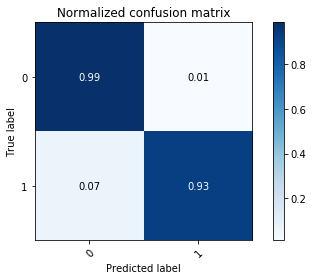

In [15]:
plot_confusion_matrix_2(y_test, y_pred, normalize=True);

### Agora, usando validação cruzada.

In [16]:
classificador = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p = 2)
classificador.fit(x, y)

resultados = cross_val_score(classificador, x, y, cv = 200)

classe = y.values

print("Acurácia média: {:.3} ± {:.3}.".format(resultados.mean(), resultados.std()))

Acurácia média: 0.982 ± 0.0457.
